In [71]:
import sys
import numpy as np
import pandas as pd
import datetime
from pathlib import Path
import math
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

sys.path.insert(0, "../")
from eval_metrics import lift_at_k

# clone code from repos
PATH_TO_CLEANLAB = "/cleanlab/"
sys.path.insert(0, PATH_TO_CLEANLAB)
from cleanlab.rank import order_label_issues, get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.filter import find_label_issues

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Evaluate scores

In [34]:
%%time

models = [
    "resnet18", 
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224"
]

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

results_list = []
pred_probs_list = [] # use for ensemble scoring
labels_list = [] # use for sanity check (labels from each model should be the same because they were generated from the same cross-val procedure

for model in models:
    
    # read numpy files
    numpy_out_folder = f"./dcai_train_val_dataset_cv_{model}/"
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    labels = np.load(numpy_out_folder + "labels.npy")
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
    label_errors_target = np.load(numpy_out_folder + "label_errors_mask.npy") # known label errors
    
    # save to list for ensemble scoring
    pred_probs_list.append(pred_probs)
    
    labels_list.append(labels)
    
    for score_param in score_params:
        
        method, adjust_pred_probs = score_param

        # compute scores
        label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute Lift@K evaluation metric
        lift_at_k_dict = {}
        for k in range(100, 500, 100):
            lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)

        # save results
        results = {
            "dataset": "andrew-ng-dcai",
            "model": model,
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "auroc": auroc
        }

        # add the lift at k metrics
        results.update(lift_at_k_dict)

        # save results
        results_list.append(results)

CPU times: user 1.75 s, sys: 0 ns, total: 1.75 s
Wall time: 1.75 s


In [35]:
# use for sanity check (noisy labels from each model should be the same because they were generated from the same cross-val procedure
for i, labels_temp in enumerate(labels_list):
    
    if i == 0:
        labels_temp_previous = labels_temp.copy()
    else:
        assert (labels_temp_previous == labels_temp).all()

## Evaluate ensemble scores

In [36]:
%%time

for score_param in score_params:

    method, adjust_pred_probs = score_param
    
    print(f"Scoring label quality...")
    print(f"  method: {method}")
    print(f"  adjust_pred_probs: {adjust_pred_probs}")

    label_quality_ensemble_scores = get_label_quality_ensemble_scores(labels, pred_probs_list, method=method, adjust_pred_probs=adjust_pred_probs)
    
    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_ensemble_scores)

    # compute Lift@K evaluation metric
    lift_at_k_dict = {}
    for k in range(100, 500, 100):
        lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_ensemble_scores, k=k)

    # save results
    results = {
        "dataset": "andrew-ng-dcai",
        "model": "ensemble (all)",
        "method": method,
        "adjust_pred_probs": adjust_pred_probs,
        "auroc": auroc
    }

    # add the lift at k metrics
    results.update(lift_at_k_dict)
    
    # save results
    results_list.append(results)

Scoring label quality...
  method: self_confidence
  adjust_pred_probs: False
Weighting scheme for ensemble: accuracy
Ensemble members will be weighted by: accuracy of member / (sum of accuracy from all members)
  Model 0 accuracy : 0.7831155068880254
  Model 0 weights  : 0.203843324751747
  Model 1 accuracy : 0.7089367714588485
  Model 1 weights  : 0.18453475542478853
  Model 2 accuracy : 0.7114093959731543
  Model 2 weights  : 0.18517837440235382
  Model 3 accuracy : 0.8163193217944189
  Model 3 weights  : 0.21248620816476646
  Model 4 accuracy : 0.8219710349699753
  Model 4 weights  : 0.21395733725634425
Scoring label quality...
  method: self_confidence
  adjust_pred_probs: True
Weighting scheme for ensemble: accuracy
Ensemble members will be weighted by: accuracy of member / (sum of accuracy from all members)
  Model 0 accuracy : 0.7831155068880254
  Model 0 weights  : 0.203843324751747
  Model 1 accuracy : 0.7089367714588485
  Model 1 weights  : 0.18453475542478853
  Model 2 accu

## Create DataFrame with results

In [37]:
df = pd.DataFrame(results_list)

In [38]:
df

,dataset,model,method,adjust_pred_probs,auroc,lift_at_100,lift_at_200,lift_at_300,lift_at_400
0,andrew-ng-dcai,resnet18,self_confidence,False,0.812958,5.935968,4.908589,4.261720,3.748031
1,andrew-ng-dcai,resnet18,self_confidence,True,0.817624,5.707661,4.642231,4.185618,3.881210
2,andrew-ng-dcai,resnet18,normalized_margin,False,0.803109,4.261720,3.995363,3.805108,3.462648
3,andrew-ng-dcai,resnet18,normalized_margin,True,0.804237,4.109516,3.843159,3.551434,3.424597
4,andrew-ng-dcai,resnet18,confidence_weighted_entropy,False,0.810511,6.012070,4.794435,4.236353,3.690954
5,andrew-ng-dcai,resnet50d,self_confidence,False,0.788761,5.555457,4.451976,4.084149,3.576801
6,andrew-ng-dcai,resnet50d,self_confidence,True,0.792971,4.946640,4.147567,3.906577,3.557776
7,andrew-ng-dcai,resnet50d,normalized_margin,False,0.762171,3.576801,3.120188,2.967984,2.815780
8,andrew-ng-dcai,resnet50d,normalized_margin,True,0.763896,4.185618,3.767056,3.170923,2.872856
9,andrew-ng-dcai,resnet50d,confidence_weighted_entropy,False,0.790047,5.479355,4.642231,4.134884,3.595827


## Export results to csv

In [39]:
# export results to CSV file
ts = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
df.to_csv(f"label_quality_scores_evaluation_{ts}.csv", index=False)

## Display top images ranked by label quality scores (ascending)

In [77]:
# read pred_probs (again)

model = "swin_base_patch4_window7_224"
method = "self_confidence"
adjust_pred_probs = False

numpy_out_folder = f"./dcai_train_val_dataset_cv_{model}/"
pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
labels = np.load(numpy_out_folder + "labels.npy")
images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
label_errors_target = np.load(numpy_out_folder + "label_errors_mask.npy") # known label errors

# get label quality scores (again)
label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

In [78]:
df_temp = pd.DataFrame({
    "label_quality_scores": label_quality_scores,
    "images": images,
    "labels": labels,
    "label_errors_target": label_errors_target
})

prefix = "/Data/andrew-ng-dcai-comp-2021-data-deduped/andrew-ng-dcai-comp-2021-data/" # path to dataset
df_temp["file_paths"] = df_temp.images.map(lambda x: prefix + "/".join(Path(x).parts[-3:]))

In [83]:
# df_temp.sort_values(by="label_quality_scores", ascending=True).head(2)

Text(0.5, 0.98, 'Top 20 Images Ranked By Label Quality Score \n Scoring Method: self_confidence \n Model: swin_base_patch4_window7_224')

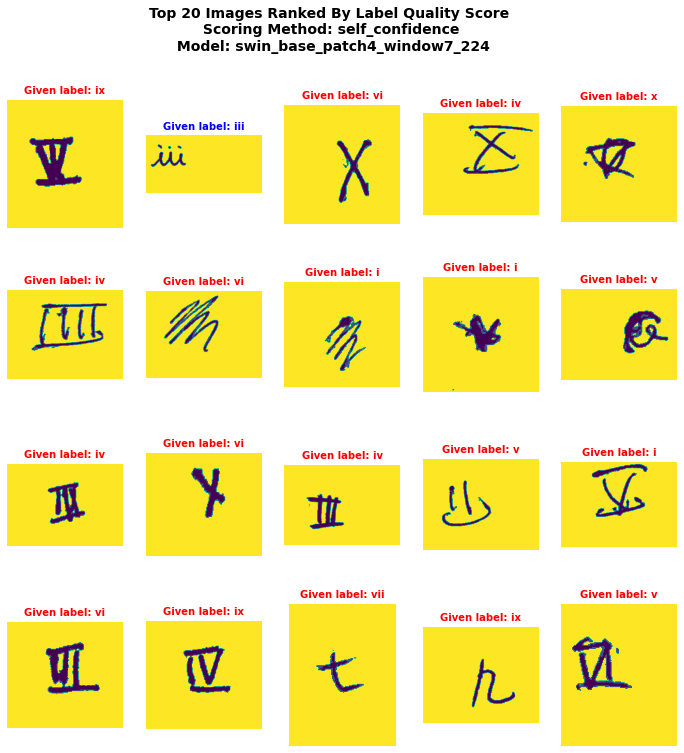

In [93]:
TOP_K = 20
df_filtered = df_temp.sort_values(by="label_quality_scores", ascending=True).head(TOP_K)

# list of image paths
# e.g. "../data/train/i/foo.png"
image_paths = df_filtered.file_paths.tolist()
image_labels = df_filtered.labels.tolist()
image_errors = df_filtered.label_errors_target.tolist()

# count of images
image_cnt = len(image_paths)

# configure grid
GRID_SAVE_PATH = f"./top_{TOP_K}_images_by_{model}_{method}_grid.png"

fig_size = 12  # resolution; 1 = 100px
num_cols = 5  # set the number of desired columns
num_rows = math.ceil(
    image_cnt / num_cols
)  # number of rows will be automatically set
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_size, fig_size))

# loop through each image
for idx, image_path in enumerate(image_paths):

    # given label
    given_label = Path(image_path).parts[-2]

    # set the position of the image on the grid
    row_pos = idx // num_cols
    col_pos = idx % num_cols

    # read image
    plt_image = plt.imread(image_path)

    # show image
    axes[row_pos, col_pos].axis("off")
    #     axes[row_pos, col_pos].set_facecolor('xkcd:salmon')

    error = image_errors[idx]
    title_color = ("b", "r")[error]

    axes[row_pos, col_pos].set_title(
        f"Given label: {given_label}", size=10, fontweight="bold", color=title_color
    )
    axes[row_pos, col_pos].imshow(plt_image)

plt.suptitle(f"Top 20 Images Ranked By Label Quality Score \n Scoring Method: {method} \n Model: {model}", size=14, fontweight="bold")
# plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
# plt.savefig(GRID_SAVE_PATH)